# PepBERT - small

Saved embeddings and t-SNE coordinates to ../data/small_PepBERT_embeddings.csv


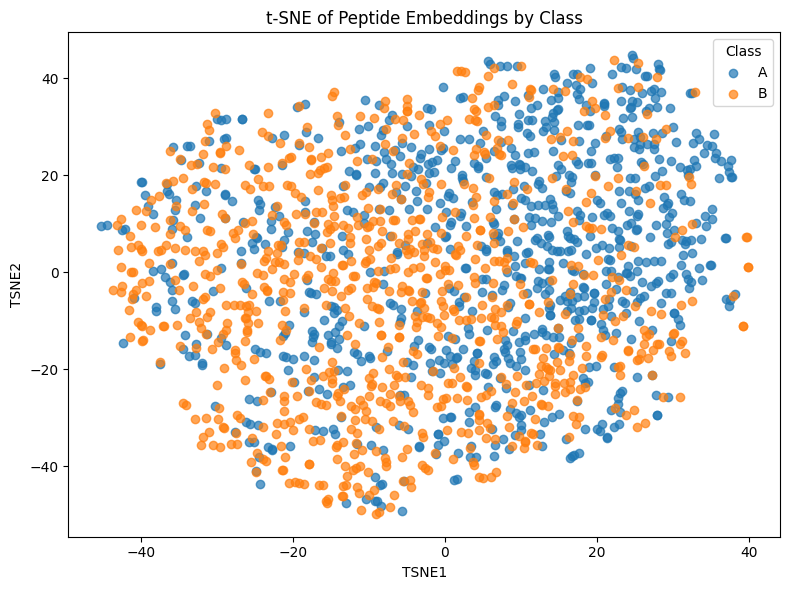

In [1]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tokenizers import Tokenizer
from huggingface_hub import hf_hub_download
import importlib.util

# Define the repository ID for the PepBERT model
repo_id = "dzjxzyd/PepBERT-small-UniRef100"

# Function to load a module from the Hugging Face Hub
def load_module_from_hub(repo_id: str, filename: str):
    file_path = hf_hub_download(repo_id=repo_id, filename=filename)
    module_name = os.path.splitext(os.path.basename(file_path))[0]
    spec = importlib.util.spec_from_file_location(module_name, file_path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module

# Load model architecture and configuration
model_module = load_module_from_hub(repo_id, "model.py")
config_module = load_module_from_hub(repo_id, "config.py")
build_transformer = model_module.build_transformer
get_config = config_module.get_config

# Load the tokenizer
tokenizer_path = hf_hub_download(repo_id=repo_id, filename="tokenizer.json")
tokenizer = Tokenizer.from_file(tokenizer_path)

# Download model weights
weights_path = hf_hub_download(repo_id=repo_id, filename="tmodel_12.pt")

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = get_config()
model = build_transformer(
    src_vocab_size=tokenizer.get_vocab_size(),
    src_seq_len=config["seq_len"],
    d_model=config["d_model"]
)
state = torch.load(weights_path, map_location=device)
model.load_state_dict(state["model_state_dict"])
model.to(device).eval()

# Function to encode a single peptide sequence
def encode_peptide(sequence):
    # Add start and end tokens
    encoded_ids = [tokenizer.token_to_id("[SOS]")] + tokenizer.encode(sequence).ids + [tokenizer.token_to_id("[EOS]")]
    input_ids = torch.tensor([encoded_ids], dtype=torch.int64).to(device)
    encoder_mask = torch.ones((1, 1, 1, input_ids.size(1)), dtype=torch.int64).to(device)
    with torch.no_grad():
        emb = model.encode(input_ids, encoder_mask)
    # remove SOS/EOS positions and average
    emb_core = emb[:, 1:-1, :]
    emb_avg = emb_core.mean(dim=1)
    return emb_avg.squeeze().cpu().numpy()

# Load your dataset
df = pd.read_csv("../data/train.csv")  # ensure .csv extension

# Encode all sequences
embeddings_list = df["Sequence"].apply(encode_peptide).tolist()
# Create embeddings DataFrame
embeddings_df = pd.DataFrame(embeddings_list)

# Run t-SNE on the high-dimensional embeddings (exclude Intensity)
tsne = TSNE(n_components=2, random_state=42)
emb_tsne = tsne.fit_transform(embeddings_df.values)
# Add t-SNE results to DataFrame
tsne_df = pd.DataFrame(emb_tsne, columns=["TSNE1", "TSNE2"])

# Combine original data, embeddings, and t-SNE results
result_df = pd.concat([df[["Sequence", "Class"]], embeddings_df, tsne_df], axis=1)

# Save combined DataFrame to a new CSV
output_path = "../data/small_PepBERT_embeddings.csv"
result_df.to_csv(output_path, index=False)
print(f"Saved embeddings and t-SNE coordinates to {output_path}")

# Plotting
groups = result_df.groupby("Class")
plt.figure(figsize=(8, 6))
for cls, group in groups:
    plt.scatter(group["TSNE1"], group["TSNE2"], label=cls, alpha=0.7)
plt.title("t-SNE of Peptide Embeddings by Class")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.legend(title="Class")
plt.tight_layout()
plt.savefig("../train_small_PepBERT.png", dpi=300)
plt.show()